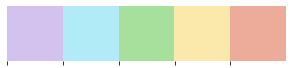

In [1]:
import json
import os
import shutil
import glob
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import cv2
import seaborn as sns
import missingno as msno 
import altair as alt
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

# Set Color Palettes for the notebook
colors_nude = ['#D3C2ED', '#B0EBF7', '#A7E09D', '#FAE9AA', '#EDAB9A']
sns.palplot(sns.color_palette(colors_nude))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

In [2]:
for i, c in enumerate([10,12]):
    print(i, c)
    

0 10
1 12


In [3]:
base_path = "./ISIC-Archive/Data/"
csv_path = os.path.join(base_path, "metadata.csv")

In [4]:
_df = pd.read_csv(csv_path)
_df

,ID,dcm_name,age,anatomy,benign_malignant,diagnosis,sex,target
0,5436e3acbae478396759f0d1,ISIC_0000001,30.0,anterior torso,benign,nevus,female,0
1,5436e3acbae478396759f0d3,ISIC_0000002,60.0,upper extremity,malignant,melanoma,female,1
2,5436e3acbae478396759f0d5,ISIC_0000003,30.0,upper extremity,benign,nevus,male,0
3,5436e3acbae478396759f0d9,ISIC_0000005,40.0,anterior torso,benign,nevus,female,0
4,5436e3acbae478396759f0df,ISIC_0000008,30.0,anterior torso,benign,nevus,female,0
...,...,...,...,...,...,...,...,...
22918,IP_3970525,ISIC_9974166,45.0,torso,benign,nevus,female,0
22919,IP_9245079,ISIC_9975949,40.0,torso,benign,nevus,male,0
22920,IP_2673125,ISIC_9977219,60.0,torso,benign,nevus,male,0
22921,IP_3091321,ISIC_9979765,45.0,torso,benign,nevus,male,0


In [5]:
_df['diagnosis'].unique()

array(['nevus', 'melanoma', 'seborrheic keratosis', 'lichenoid keratosis',
       'basal cell carcinoma', 'angioma', 'solar lentigo', 'lentigo NOS',
       'lentigo simplex', 'actinic keratosis', 'dermatofibroma',
       'atypical melanocytic proliferation',
       'angiofibroma or fibrous papule', 'squamous cell carcinoma',
       'scar', 'cafe-au-lait macule'], dtype=object)

In [6]:
_df['diagnosis'].replace(r'unknown', np.nan, inplace = True)
_df['diagnosis'].replace(r'other', np.nan, inplace = True)

In [7]:
# m = _df['variable'].isna().groupby(df['name']).all()
m = _df['diagnosis'].isna()
df_diagnosis = _df[~m]

In [8]:
data_path = '/media/mestecha/Samsung_T5/SAGAN/ISIC-Archive/Data/Images/'
images = df_diagnosis['dcm_name'].tolist()
len(images)

22923

___

In [9]:
from os import listdir
from os.path import isfile, join

fullfiles = []

for path, subdirs, files in os.walk(data_path):
        for name in files:
            if os.path.splitext(name)[0] in images:
#                 if corrupted_image(os.path.join(path, name)):
#                     corrupted.append(os.path.join(path, name))
                fullfiles.append(os.path.join(path, name))

In [10]:
len(fullfiles)

22923

In [11]:
from skimage import io

def corrupted_image(img_file):
    try:
        img = io.imread(img_file)
    except:
        return True
    return False

corrupted = []
for i in range(len(fullfiles)):
    if corrupted_image(fullfiles[i]):
        corrupted.append(fullfiles[i])

In [12]:
corrupted

['/media/mestecha/Samsung_T5/SAGAN/ISIC-Archive/Data/Images/ISIC_0011433.jpeg']

In [13]:
df_diagnosis = df_diagnosis[df_diagnosis.dcm_name != 'ISIC_0011433']
df_diagnosis

,ID,dcm_name,age,anatomy,benign_malignant,diagnosis,sex,target
0,5436e3acbae478396759f0d1,ISIC_0000001,30.0,anterior torso,benign,nevus,female,0
1,5436e3acbae478396759f0d3,ISIC_0000002,60.0,upper extremity,malignant,melanoma,female,1
2,5436e3acbae478396759f0d5,ISIC_0000003,30.0,upper extremity,benign,nevus,male,0
3,5436e3acbae478396759f0d9,ISIC_0000005,40.0,anterior torso,benign,nevus,female,0
4,5436e3acbae478396759f0df,ISIC_0000008,30.0,anterior torso,benign,nevus,female,0
...,...,...,...,...,...,...,...,...
22918,IP_3970525,ISIC_9974166,45.0,torso,benign,nevus,female,0
22919,IP_9245079,ISIC_9975949,40.0,torso,benign,nevus,male,0
22920,IP_2673125,ISIC_9977219,60.0,torso,benign,nevus,male,0
22921,IP_3091321,ISIC_9979765,45.0,torso,benign,nevus,male,0


___

In [14]:
from sklearn.model_selection import train_test_split
path = '/media/mestecha/Samsung_T5/SAGAN/ISIC-Archive/Data'

In [15]:
y = df_diagnosis['target']

In [16]:
len(df_diagnosis)

22922

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_diagnosis, y, test_size=0.1, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [18]:
print(f'Train  feature size: {len(X_train)}')
# print(f'Validation feature size: {len(X_val)}')
print(f'Test feature size: {len(X_test)}')
print(f'Train target size: {len(y_train)}')
# print(f'Validation target size: {len(y_val)}')
print(f'Test target size: {len(y_test)}')

Train  feature size: 20629
Test feature size: 2293
Train target size: 20629
Test target size: 2293


In [19]:
df_diagnosis.to_csv(os.path.join(path, 'metadata.csv'), index = False, header=True)
X_train.to_csv(os.path.join(path, 'train_data.csv'), index = False, header=True)
# X_val.to_csv(os.path.join(path, 'val_data.csv'), index = False, header=True)
X_test.to_csv(os.path.join(path, 'test_data.csv'), index = False, header=True)

___

In [188]:
X_tiny, X_null, y_tiny, y_null = train_test_split(X_train, y_train, test_size=0.99, stratify=y_train)

In [189]:
print(f'Tiny  feature size: {len(X_tiny)}')
print(f'Null feature size: {len(X_null)}')
print(f'Tiny target size: {len(y_tiny)}')
print(f'Null target size: {len(y_null)}')

Tiny  feature size: 146
Null feature size: 14524
Tiny target size: 146
Null target size: 14524


In [192]:
X_tiny.to_csv(os.path.join(path, 'tiny_data.csv'), index = False, header=True)

___

In [35]:
len(df_diagnosis['diagnosis'].unique())

16

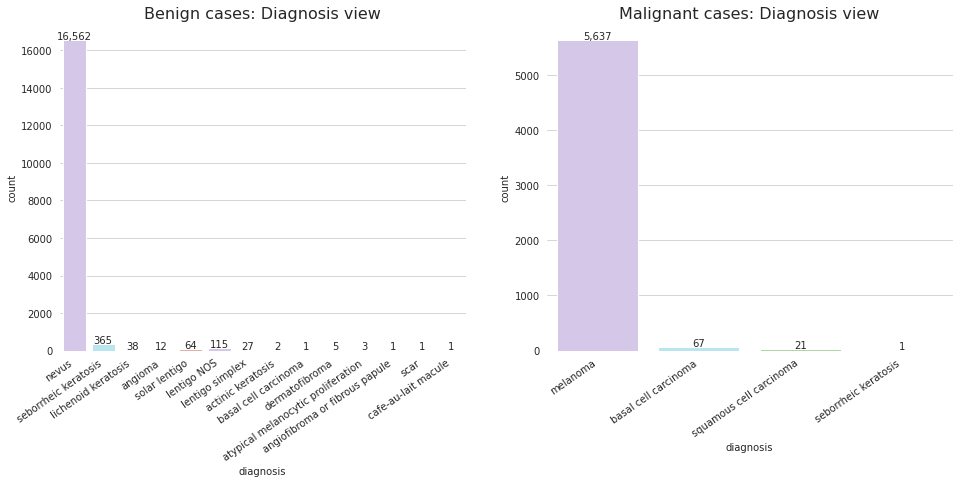

In [31]:
# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(df_diagnosis[df_diagnosis['target']==0]['diagnosis'], ax=ax1, palette = colors_nude)
b = sns.countplot(df_diagnosis[df_diagnosis['target']==1]['diagnosis'], ax=ax2, palette = colors_nude)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
for p in b.patches:
    b.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
ax1.set_title('Benign cases: Diagnosis view', fontsize=16)
ax2.set_title('Malignant cases: Diagnosis view', fontsize=16)
sns.despine(left=True, bottom=True);